In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'plant-village:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F414960%2F793497%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240803%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240803T091429Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D7ac3cc9e8a26610489f00016789542718529004867dcc7069e6fd438e84c79a5ac3e4910f40e3ad6a102f3d3ace37fae2514561a2e5c148fd78b140d28f52c9691cf7a007c0b0efebc2eaa27aa8c5c95aa3dd265e12b09a031e5a63fdd2f3a621f46ad3b3fc43c24db8c401e5b558802890798f1d5aecf848047a56b776d5ef4bddc568a3bfe1ff2cfaf2c5c429024714c7252e1e86f93b02ff389f240020fec3fac3b764adb0760c8eacfb26f16e3c831dd5a493d44a2e6ad04761aa58553aaef14f0ad7d159bd33a01e59cdea6a74b7cdbb32d0ec1d5bcffeb37aa32fb772c59b2d74d2b6cf1065352e722e2be1b7519fbfdec503f0d9a3a47022a9c328a25'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 344488049 bytes downloaded
Downloaded and uncompressed: plant-village
Data source import complete.


# Problem Statement
Farmers every year face economic loss and crop waste due to various diseases in potato plants.  Early blight and Late blight are major disease of potato leaf. It is estimated that the major loss occurred in potato yield is due to these diseases. Thus the images are classified into 3 classes :
- Healthy leaves     
<img src="https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Ftse1.mm.bing.net%2Fth%3Fid%3DOIP.jW152ASG2nfRv_LCkYnzMQHaFj%26pid%3DApi&f=1" height='200' width="300"/>

- Late Blight leaves
<img src="https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Ftse2.mm.bing.net%2Fth%3Fid%3DOIP.vCrNUKDj1Z1zErHEMQzmCQHaFj%26pid%3DApi&f=1" height='200' width="300"/>

- Early Blight leaves
<img src="https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Ftse2.mm.bing.net%2Fth%3Fid%3DOIP.e4wvw_JVbE1yFgOYbUoVSAHaE7%26pid%3DApi&f=1" height='200' width="300"/>

Project inspiration : https://youtube.com/playlist?list=PLeo1K3hjS3utJFNGyBpIvjWgSDY0eOE8S

In [2]:
# import libraries
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # to disable all debugging logs

In [3]:
# importing dataset
dir = os.listdir('../input/plant-village/PlantVillage')
for filenames in dir:
    print(filenames)

Potato___Early_blight
Tomato_Spider_mites_Two_spotted_spider_mite
Potato___Late_blight
Tomato_Septoria_leaf_spot
Pepper__bell___healthy
Tomato_Early_blight
Tomato_Leaf_Mold
Tomato__Target_Spot
Pepper__bell___Bacterial_spot
Potato___healthy
Tomato_Late_blight
Tomato_Bacterial_spot
Tomato_healthy
Tomato__Tomato_YellowLeaf__Curl_Virus
Tomato__Tomato_mosaic_virus


# Extracting only potato dataset

In [4]:
!cp -rf ../input/plant-village/PlantVillage/Potato___Early_blight ./Potato___Early_blight

In [5]:
!cp -rf ../input/plant-village/PlantVillage/Potato___Late_blight ./Potato___Late_blight

In [6]:
!cp -rf ../input/plant-village/PlantVillage/Potato___healthy ./Potato___healthy

In [7]:
Current_Dir = os.getcwd()
dataset_dir = pathlib.Path(Current_Dir)
print(dataset_dir)

/content


In [8]:
#Global initialization of some imp variables
Image_Size = 256
Batch_Size = 32
Channels = 3
Epochs = 40


In [9]:
#yields batches of images from the subdirectories class_a , class_b and class_c
#together with labels 0 , 1 and 2 (0, 1, 2 corresponding to classes class_a , class_b and class_c respectively )
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir, batch_size = Batch_Size, image_size = (Image_Size, Image_Size), shuffle = True)

Found 2152 files belonging to 4 classes.


In [10]:
#Folders(classes) in 'Dataset' directory
class_name = dataset.class_names
class_name

['Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'sample_data']

In [11]:
len(dataset) # Number of Batches = (total number of files belonging to all classes / Batch_Size)

68

In [12]:
print(dataset) #prints Elements in dataset: here 1st element is image and 2nd index of that image.

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


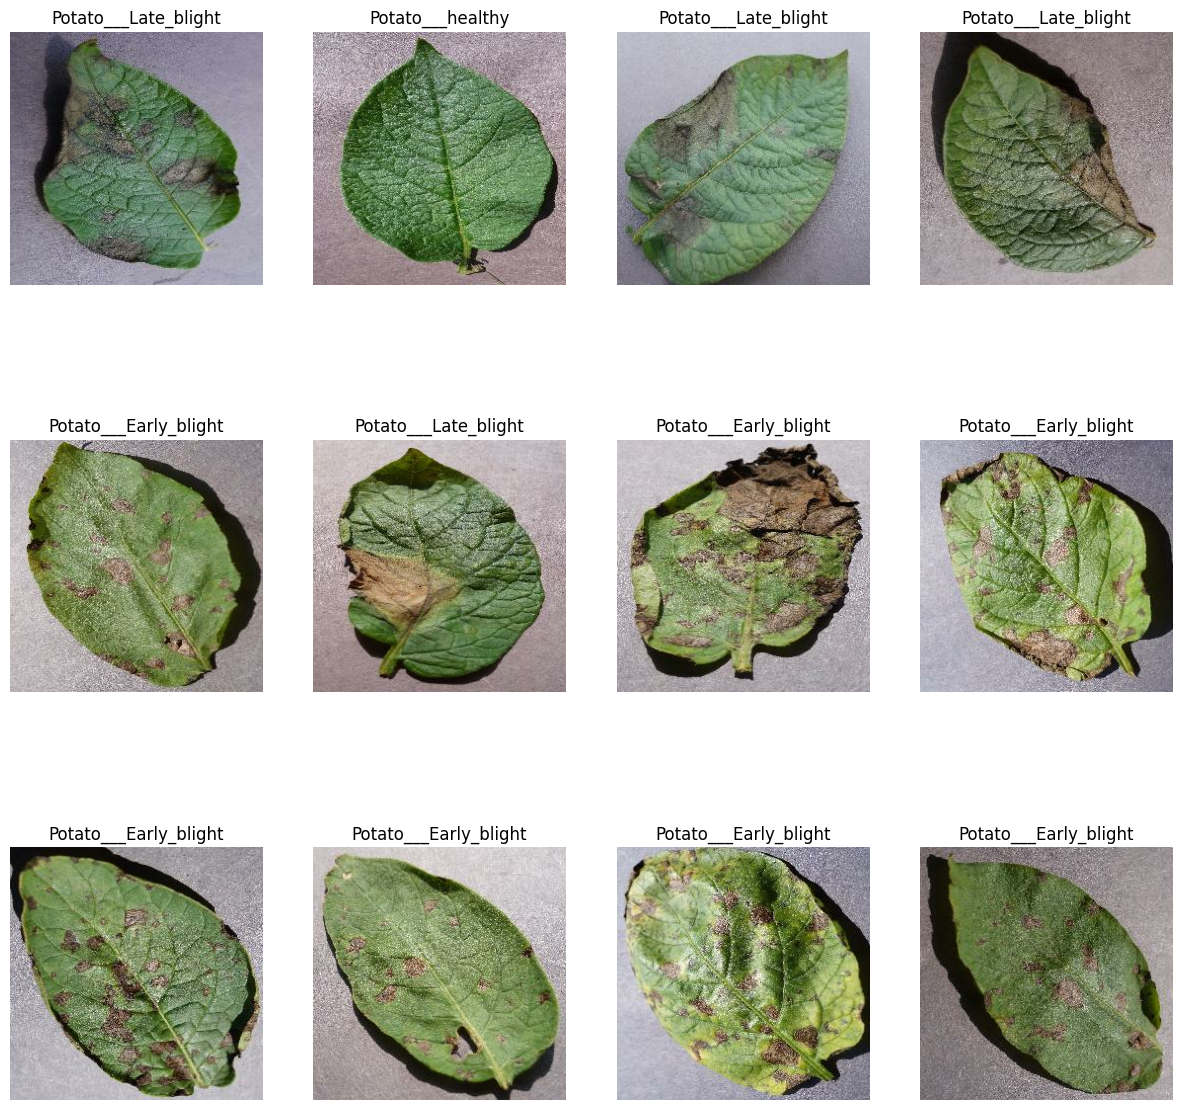

In [13]:
# Plotting the image
plt.figure(figsize = (15,15))
# dataset.take(count) : Creates a Dataset with at most 'count' elements(batch) from the dataset
for image, label in dataset.take(1):
    for i in range(12):
        plt.subplot(3, 4, i+1) # many plots at a time =>subpots
        plt.imshow(image[i].numpy().astype('uint8')) #converting all data of image into numpy and than to intiger type as they were in float.
        plt.title(class_name[label[i]])  # title of the class_name of image
        plt.axis("off") # Hide the values of graph


# Splitting Dataset

In [14]:
# Function for Splitting the data
def split_dataset(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 10)

    ds_size = len(ds)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [15]:
train_data, val_data, test_data = split_dataset(dataset)

In [16]:
print("Size of Data is :{0} \nBatch size of Training Data is :{1}\nBatch size of Validation Data is :{2} \nBatch size of Testing Data is :{3} " .format(len(dataset), len(train_data), len(val_data), len(test_data)))

Size of Data is :68 
Batch size of Training Data is :54
Batch size of Validation Data is :6 
Batch size of Testing Data is :8 


In [17]:
# caching,shuffle and prefetching the data
train_ds = train_data.cache().shuffle(100).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_data.cache().shuffle(100).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_data.cache().shuffle(100).prefetch(buffer_size = tf.data.AUTOTUNE)

# Data Pre-processing

In [18]:
# Image Preprocessing : Rescaling and Resizing
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(Image_Size, Image_Size),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [19]:
# Data augmentation by flipping and rotating existing images
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(factor = 0.5)
])

# Model Building

In [20]:
# Creating Convolution layer
input_shape = (Batch_Size, Image_Size, Image_Size, Channels)
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(filters = 16, kernel_size = (3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(128, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(128, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Flatten(),
    layers.Dense(128, activation = 'relu'),
    layers.Dense(64, activation = 'softmax'),

])


model.build(input_shape = input_shape)

In [21]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        9280      
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [22]:
# Optimizing the model 'SparseCategoricalCrossentropy'=>as there are many categorical classes of data
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy'])

In [23]:
#Fit the model with training data and also pass validation data
history = model.fit(
train_data, epochs = Epochs, batch_size = Batch_Size, verbose = 1, validation_data = val_data)

Epoch 1/40
54/54 [==============================] - 25s 413ms/step - loss: 1.2574 - accuracy: 0.4660 - val_loss: 0.9072 - val_accuracy: 0.4948
Epoch 2/40
54/54 [==============================] - 22s 406ms/step - loss: 0.9089 - accuracy: 0.4959 - val_loss: 0.8530 - val_accuracy: 0.5104
Epoch 3/40
54/54 [==============================] - 22s 412ms/step - loss: 0.7863 - accuracy: 0.6019 - val_loss: 0.6956 - val_accuracy: 0.7396
Epoch 4/40
54/54 [==============================] - 22s 401ms/step - loss: 0.6072 - accuracy: 0.7424 - val_loss: 0.4638 - val_accuracy: 0.8021
Epoch 5/40
54/54 [==============================] - 22s 406ms/step - loss: 0.4192 - accuracy: 0.8269 - val_loss: 0.4508 - val_accuracy: 0.7969
Epoch 6/40
54/54 [==============================] - 22s 407ms/step - loss: 0.3251 - accuracy: 0.8703 - val_loss: 0.2132 - val_accuracy: 0.9286
Epoch 7/40
54/54 [==============================] - 22s 407ms/step - loss: 0.2332 - accuracy: 0.9043 - val_loss: 0.2315 - val_accuracy: 0.9115

In [24]:
scores = model.evaluate(train_data)

54/54 [==============================] - 5s 94ms/step - loss: 0.1163 - accuracy: 0.9501


In [25]:
history

In [26]:
history.params

{'verbose': 1, 'epochs': 40, 'steps': 54}

In [27]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

# Analyzing the Output

In [28]:
# Getting the model history to analyse
train_loss = history.history['loss']
train_acc = history.history['accuracy']

val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']


Text(0.5, 1.0, 'Training and Validation Loss')

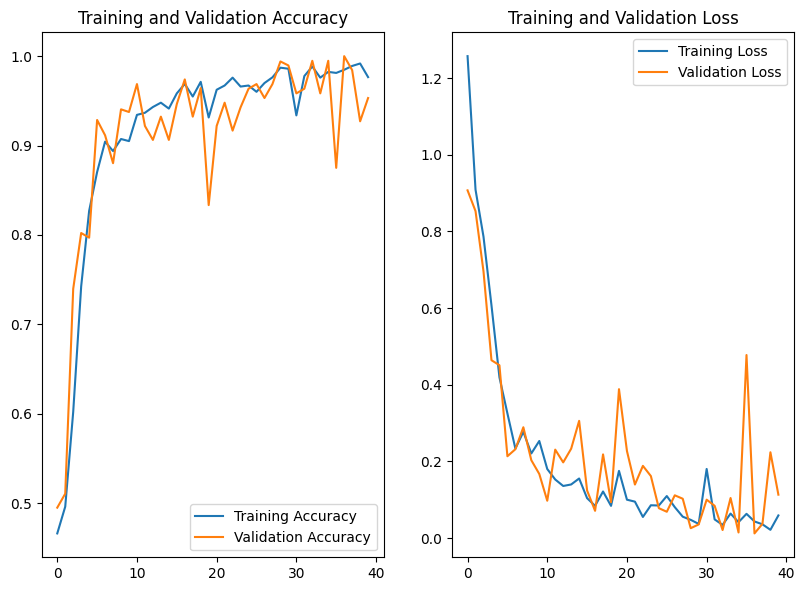

In [29]:
#graphs for accuracy and loss of training and validation data
plt.figure(figsize = (15,15))
plt.subplot(2,3,1)
plt.plot(range(Epochs), train_acc, label = 'Training Accuracy')
plt.plot(range(Epochs), val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2,3,2)
plt.plot(range(Epochs), train_loss, label = 'Training Loss')
plt.plot(range(Epochs), val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')

First Image of batch to predict :
Actual label :  Potato___Late_blight
1/1 [==============================] - 0s 215ms/step
Predicted label :  Potato___Late_blight


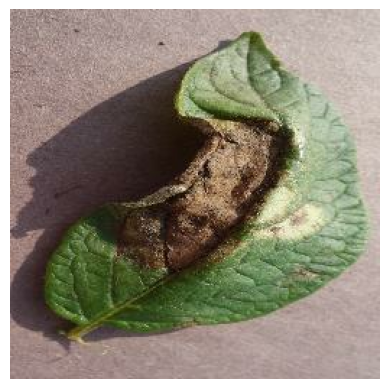

In [30]:
#plotting image
for batch_image, batch_label in train_data.take(1):
    first_image = batch_image[0].numpy().astype('uint8')
    first_label = class_name[batch_label[0]]

    print('First Image of batch to predict :')
    plt.imshow(first_image)
    print('Actual label : ', first_label)

    batch_prediction = model.predict(batch_image)
    print('Predicted label : ', class_name[np.argmax(batch_prediction[0])])
    plt.axis('off')

1/1 [==============================] - 0s 116ms/step


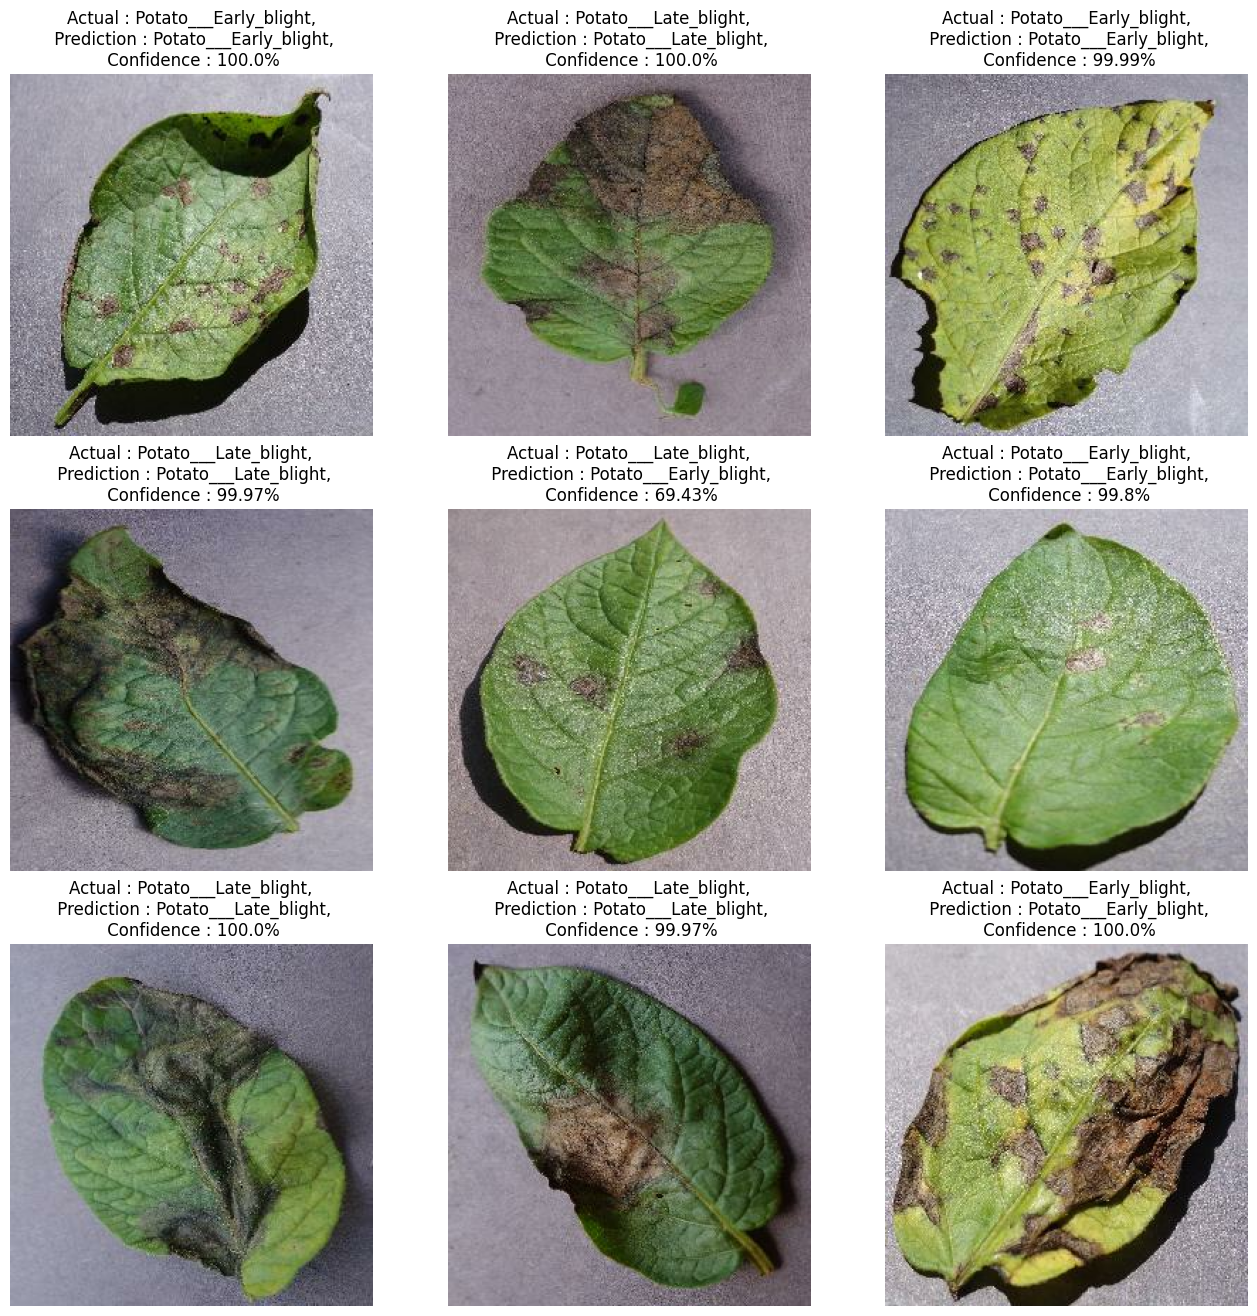

In [31]:
# plotting batch of images with its actual label, predicted label and confidence
plt.figure(figsize = (16,16))
for batch_image, batch_label in train_data.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        image = batch_image[i].numpy().astype('uint8')
        label = class_name[batch_label[i]]

        plt.imshow(image)

        batch_prediction = model.predict(batch_image)
        predicted_class = class_name[np.argmax(batch_prediction[i])]
        confidence = round(np.max(batch_prediction[i]) * 100, 2)

        plt.title(f'Actual : {label},\n Prediction : {predicted_class},\n Confidence : {confidence}%')

        plt.axis('off')

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define U-Net model
def unet_model(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Encoding path
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoding path
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4], axis=-1)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3], axis=-1)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2], axis=-1)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1], axis=-1)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)  # Ensure this matches the ground truth shape

    model = models.Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Define input shape
Image_Size = 256
input_shape = (Image_Size, Image_Size, 3)

# Create and compile the model
model = unet_model(input_shape)

# Define preprocessing function
def preprocess_mask(mask):
    return tf.expand_dims(mask, axis=-1)

# Apply preprocessing to datasets
train_ds = train_ds.map(lambda x, y: (x, preprocess_mask(y)))
val_ds = val_ds.map(lambda x, y: (x, preprocess_mask(y)))
test_ds = test_ds.map(lambda x, y: (x, preprocess_mask(y)))

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    verbose=1
)

# Plot training and validation metrics
import matplotlib.pyplot as plt

history_dict = history.history

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_dict['loss'])
plt.plot(history_dict['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

plt.subplot(1, 2, 2)
plt.plot(history_dict['accuracy'])
plt.plot(history_dict['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

plt.show()


Epoch 1/20
54/54 [==============================] - 743s 14s/step - loss: 6.1455 - accuracy: 0.4569 - val_loss: 5.7185 - val_accuracy: 0.4792
Epoch 2/20
54/54 [==============================] - 734s 14s/step - loss: 5.8706 - accuracy: 0.4683 - val_loss: 5.7185 - val_accuracy: 0.4792
Epoch 3/20
19/54 [=========>....................] - ETA: 7:54 - loss: 5.9191 - accuracy: 0.4605

In [36]:
import tensorflow as tf

def preprocess_mask(mask):
    # Add a channel dimension to the mask using TensorFlow operations
    return tf.expand_dims(mask, axis=-1)
def preprocess_mask(mask):
    return tf.expand_dims(mask, axis=-1)

train_ds = train_ds.map(lambda x, y: (x, preprocess_mask(y)))
val_ds = val_ds.map(lambda x, y: (x, preprocess_mask(y)))
test_ds = test_ds.map(lambda x, y: (x, preprocess_mask(y)))
outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)


NameError: name 'c9' is not defined

In [ ]:
scores = model.evaluate(train_data)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Predict on the test dataset
y_true = []  # Store true labels
y_pred = []  # Store predictions

for images, masks in test_ds:
    predictions = model.predict(images)
    y_true.extend(masks.numpy().flatten())
    y_pred.extend(predictions.flatten())

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Binarize the predictions for classification report (if binary classification)
threshold = 0.5
y_pred_binary = (y_pred > threshold).astype(int)

# Generate the classification report
report = classification_report(y_true, y_pred_binary, target_names=['Background', 'Leaf Disease'])
print(report)

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_binary)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Background', 'Leaf Disease'],
            yticklabels=['Background', 'Leaf Disease'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


### The Model shows accuracy > 97%